In [1]:
from utils import *


In [2]:
all_df = load_filtered_data(years=('2019','2020'), folder='../AIS_data', min_data_points=100)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




# Apply feature extraction
features = all_df.apply(extract_features, axis=1)


In [4]:
# Prepare train/test sets
X = features[[
            # 'duration',
            'lat_mean', 
            'lon_mean',
            'lat_std',
            'lon_std',
            # 'start_lat',
            # 'start_lon',
            # 'end_lat',
            # 'end_lon',
            # 'lat_range',
            # 'lon_range',
            'speed_mean', 
            'speed_max',
            'speed_std',
            # 'bbox_area',
            # 'accel_mean',
            # 'accel_std',
            # 'accel_max',
            ]]
# y = all_df['Label']
y = all_df['Label']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)




# Train a Random Forest classifier


clfs = {
    'RandomForest':      RandomForestClassifier(class_weight='balanced_subsample',random_state=42,n_estimators=100),
    # 'AdaBoost':          AdaBoostClassifier(random_state=42),
    # 'GradientBoosting':  GradientBoostingClassifier(random_state=42),
}
results = []
for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    # clf.fit(X_train_res, y_train_res)
    # clf.fit(X_res, y_res)

    
    y_pred = clf.predict(X_test)
    results.append({
        'model':     name,
        'accuracy':  accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall':    recall_score(y_test, y_pred, average='macro'),
        'f1':        f1_score(y_test, y_pred, average='macro')
    })

results_df = pd.DataFrame(results).set_index('model').sort_values('f1', ascending=False)
print(results_df)

# 4) (Optional) Print full classification report for the top performer
best = results_df['f1'].idxmax()
print(f"\nBest model: {best}\n")

best_model = clfs[best]
print(classification_report(y_test, best_model.predict(X_test)))




              accuracy  precision    recall        f1
model                                                
RandomForest  0.994332   0.962487  0.690075  0.768582

Best model: RandomForest

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    107549
           1       0.93      0.38      0.54       949

    accuracy                           0.99    108498
   macro avg       0.96      0.69      0.77    108498
weighted avg       0.99      0.99      0.99    108498



In [5]:
save_model(best_model, save_path='best_model.pkl')

Model saved to best_model.pkl


In [ ]:

from sklearn.metrics import classification_report
# best_model = load_model(load_path='best_model.pkl')
test_df = load_filtered_data(years=('2021',), folder='../AIS_data', min_data_points=100)


test_features = test_df.apply(extract_features, axis=1)
X_test = test_features[[
            'lat_mean', 
            'lon_mean', 
            'speed_mean', 
            'speed_max',
            # 'lat_range',
            # 'lon_range',
            # 'bbox_area',
            # 'start_lat',
            # 'start_lon',
            # 'end_lat',
            # 'end_lon',
            # 'accel_mean',
            # 'accel_std',
            # 'accel_max',
            ]]
y_test = test_df['Label']
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd23ac5e3c0>>
Traceback (most recent call last):
  File "/home/grads/a/anath/anaconda3/envs/recfish/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
y_pred = best_model.predict(X_test[:200000])
print(classification_report(y_test[:200000], y_pred))

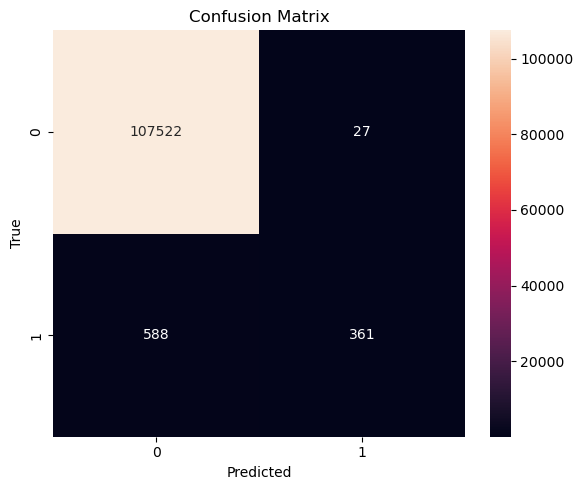

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create confusion matrix
# y_pred = clfs[best].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
importances = clfs[best].feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



# Create the bar plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df,
    palette="viridis"
)

# Invert y-axis so the most important features are at the top
ax.invert_yaxis()

# Add data labels on each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2,
            f"{width:.2f}", va='center', fontsize=11)

# Titles and labels
ax.set_title("Feature Importances", fontsize=16, pad=15)
ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
sns.despine()

plt.tight_layout()
plt.savefig("feature_importances.pdf", format='pdf')
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np



# 4) Define LSTM‐based classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, num_classes)
    def forward(self, x, lengths):
        # pack + run LSTM
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        # take last layer's hidden state: shape (batch, hidden_size)
        out = h_n[-1]
        return self.fc(out)

# 1) Custom Dataset that returns (seq_tensor, length, label)
class TripDataset(Dataset):
    def __init__(self, df):
        self.seqs, self.lengths, self.labels = [], [], []
        for _, row in df.iterrows():
            # stack into shape [seq_len, 3]
            arr = np.stack([row['elapsed_s'], row['LAT'], row['LON']], axis=1)
            tensor = torch.tensor(arr, dtype=torch.float32)
            self.seqs.append(tensor)
            self.lengths.append(tensor.size(0))
            self.labels.append(int(row['Label']))
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.seqs[idx], self.lengths[idx], self.labels[idx]

# 2) Collate fn to pad a batch
def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    labels  = torch.tensor(labels,  dtype=torch.long)
    # pad to [batch, max_len, 3]
    padded = pad_sequence(seqs, batch_first=True)
    return padded, lengths, labels

# 3) Split your DataFrame
train_df, test_df = train_test_split(
    all_df, stratify=all_df['Label'], 
    test_size=0.2, random_state=42
)

train_ds = TripDataset(train_df)
test_ds  = TripDataset(test_df)

train_loader = DataLoader(
    train_ds, batch_size=2048, shuffle=True, 
    collate_fn=collate_fn
)
test_loader  = DataLoader(
    test_ds, batch_size=2048, shuffle=False, 
    collate_fn=collate_fn
)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = LSTMClassifier().to(device)
# 0) Compute class weights on the training labels
classes       = np.unique(train_df['Label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['Label'].to_numpy()
)
# make a tensor in the same order as `classes`
weights_tensor = torch.tensor(
    [class_weights[np.where(classes == c)[0][0]] for c in range(len(classes))],
    dtype=torch.float32,
    device=device
)

# 1) Define weighted loss
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5) Training loop
model.train()
for epoch in range(1, 100):
    total_loss = 0
    for seqs, lengths, labels in train_loader:
        seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seqs, lengths)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * seqs.size(0)
    print(f"Epoch {epoch:02d} — loss: {total_loss/len(train_ds):.4f}")




In [ ]:
# 6) Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for seqs, lengths, labels in test_loader:
        seqs, lengths = seqs.to(device), lengths.to(device)
        logits = model(seqs, lengths)
        preds  = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nTest Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()